In [1]:
!curl -L -o creditcardfraud.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  10.6M      0  0:00:06  0:00:06 --:--:-- 11.5M


In [7]:
import zipfile

with zipfile.ZipFile("creditcardfraud.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.preprocessing import StandardScaler, RobustScaler

In [21]:
df = pd.read_csv('../creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<Axes: xlabel='Class', ylabel='count'>

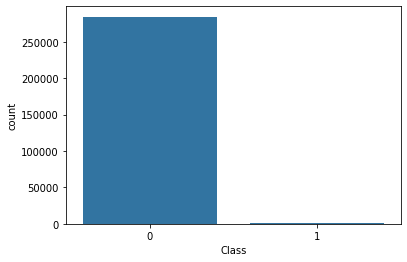

In [17]:
sns.countplot(x='Class', data=df)

In [22]:

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [23]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


In [24]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
195826,0.546811,1.992392,-0.524551,-0.274345,0.249401,-0.937411,-0.692022,-0.675612,-0.037864,1.619331,...,0.171386,0.720146,0.141563,0.047086,-0.190196,0.126281,0.011804,-0.043260,-0.181933,0
198868,0.563869,0.432554,1.861373,-4.310353,2.448080,4.574094,-2.979912,-2.792379,-2.719867,-0.276704,...,-1.384477,-0.348904,-3.979948,-0.828156,-2.419446,-0.767070,0.387039,0.319402,-0.293440,1
21881,-0.620097,0.933172,-1.263936,0.392467,-1.200550,-1.438356,-0.610893,-0.527778,0.011798,2.193340,...,0.179326,0.274763,-0.317542,-0.073363,0.427721,0.130174,-0.001827,0.048420,2.436247,0
154587,0.204678,-28.255053,21.467203,-26.871339,11.737436,-17.999630,6.065901,-41.506796,-38.987263,-13.434066,...,-21.453736,8.361985,4.909111,0.098328,-1.508739,0.008711,-5.407824,-0.183811,-0.307413,1
251891,0.832435,1.878230,1.325630,-2.333469,4.233151,1.355184,-0.853508,0.716025,-0.164910,-1.502345,...,-0.152131,-0.360736,0.043414,-0.242380,0.171098,-0.002601,-0.026667,0.005238,-0.208761,1


<Axes: xlabel='Class', ylabel='count'>

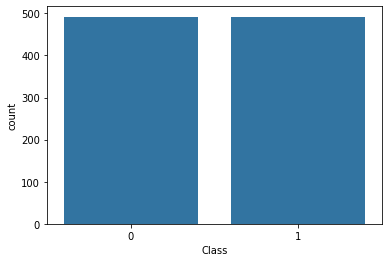

In [25]:
sns.countplot(x='Class', data=new_df)